In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
#import Image
import sys
import os
from  math import pow
from PIL import Image, ImageDraw, ImageFont
import cv2
import math
import random
import caffe

In [31]:
caffe_root = 'E:\\ndb\spyder\\caffe'

project_root = 'E:\\ndb\spyder\\caffe'

sys.path.insert(0, caffe_root + 'python')
os.environ['GLOG_minloglevel'] = '2'
 
caffe.set_mode_cpu()

In [32]:
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
def calculateDistance(x1,y1,x2,y2):  #计算人脸框的对角线距离
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist
 
def range_overlap(a_min, a_max, b_min, b_max):
 
    return (a_min <= b_max) and (b_min <= a_max)
 
def rect_overlaps(r1,r2):
    return range_overlap(r1.left, r1.right, r2.left, r2.right) and range_overlap(r1.bottom, r1.top, r2.bottom, r2.top)

In [33]:
def rect_merge(r1,r2, mergeThresh):
 
    if rect_overlaps(r1,r2):
        # dist = calculateDistance((r1.left + r1.right)/2, (r1.top + r1.bottom)/2, (r2.left + r2.right)/2, (r2.top + r2.bottom)/2)
        SI= abs(min(r1.right, r2.right) - max(r1.left, r2.left)) * abs(max(r1.bottom, r2.bottom) - min(r1.top, r2.top))
        SA = abs(r1.right - r1.left)*abs(r1.bottom - r1.top)
        SB = abs(r2.right - r2.left)*abs(r2.bottom - r2.top)
        S=SA+SB-SI
        ratio = float(SI) / float(S)
        if ratio > mergeThresh :
            return 1
    return 0

In [34]:
class Rect(object): 
    def __init__(self, p1, p2): #p1和p2为对角线上的两个点
        '''Store the top, bottom, left and right values for points
               p1 and p2 are the (corners) in either order
        '''
        self.left   = min(p1.x, p2.x) 
        self.right  = max(p1.x, p2.x)
        self.bottom = min(p1.y, p2.y)
        self.top    = max(p1.y, p2.y)
 
    def __str__(self):
        return "Rect[%d, %d, %d, %d]" % ( self.left, self.top, self.right, self.bottom )

In [35]:
def nms_average(boxes, groupThresh=2, overlapThresh=0.2): 
    rects = []
    temp_boxes = []
    weightslist = []
    new_rects = []
    for i in range(len(boxes)):
        if boxes[i][4] > 0.2:
            rects.append([boxes[i,0], boxes[i,1], boxes[i,2]-boxes[i,0], boxes[i,3]-boxes[i,1]])
 
 
    rects, weights = cv2.groupRectangles(rects, groupThresh, overlapThresh) 
 
    rectangles = []
    for i in range(len(rects)):
 
        testRect = Rect( Point(rects[i,0], rects[i,1]), Point(rects[i,0]+rects[i,2], rects[i,1]+rects[i,3]))
        rectangles.append(testRect)
    clusters = []
    for rect in rectangles:
        matched = 0
        for cluster in clusters:
            if (rect_merge( rect, cluster , 0.2) ):
                matched=1
                cluster.left   =  (cluster.left + rect.left   )/2
                cluster.right  = ( cluster.right+  rect.right  )/2
                cluster.top    = ( cluster.top+    rect.top    )/2
                cluster.bottom = ( cluster.bottom+ rect.bottom )/2
 
        if ( not matched ):
            clusters.append( rect )
    result_boxes = []
    for i in range(len(clusters)):
 
        result_boxes.append([clusters[i].left, clusters[i].bottom, clusters[i].right, clusters[i].top, 1])
 
    return result_boxes

In [36]:
def generateBoundingBox(featureMap, scale): #由于做了scale变换，所以在这里还要将坐标反变换回去
    boundingBox = [] #存储候选框，以及属于人脸的概率
    stride = 32 #感受野的大小，filter大小,这个需要自己不断地去调整；
    cellSize = 227 #人脸框的大小，它这里是认为特征图上的一块区域的prob大于95%，就以那个点在原始图像中相应的位置作为人脸框的左上角点，然后框出候选框，但这么做感觉会使候选框变多
    #遍历最终的特征图，寻找属于人脸的概率大于95%的那些区域，加上Box
    for (x,y), prob in np.ndenumerate(featureMap):
        if(prob >= 0.95):
            boundingBox.append([float(stride * y)/ scale,
                                float(x * stride)/scale,
                                float(stride * y + cellSize - 1)/scale,
                                float(stride * x + cellSize - 1)/scale, prob])
 
    return boundingBox

In [37]:
def face_detection(imgFile):
    net_full_conv = caffe.Net(os.path.join(project_root, 'faceDetection', 'deploy_full_conv.prototxt'),
                              os.path.join(project_root, 'faceDetection', 'bvlc_alexnet.caffemodel'),
                              caffe.TEST)#全卷积网络(导入训练好的模型和deploy配置文件)
    randNum = random.randint(1,10000) #设置一个在1到10000之间的随机数
     
     
     
    scales = []  #设置几个scale，组成图像金字塔
    factor = 0.793700526  #图像放大或者缩小的一个因子（经验值）
 
     
    img = cv2.imread(imgFile) #读入测试图像
 
     
    largest = min(2, 4000/max(img.shape[0:2])) #设定做scale变幻时最大的scale
    scale = largest
    minD = largest*min(img.shape[0:2]) #设定最小的scale
    while minD >= 227: #只要最小的边做完最大的scale变换后大于227，之前得到的largest就可以作为最大的scale来用，并依此乘上factor，加入到scale列表中
        scales.append(scale)
        scale *= factor
        minD *= factor
 
    total_boxes = []  #存储所有的候选框
    #进行多尺度的人脸检测
    for scale in scales:
 
        scale_img = cv2.resize(img,((int(img.shape[0] * scale), int(img.shape[1] * scale))))  #调整图像的长和高
        cv2.imwrite('E:\\ndb\\spyder\\caffe\\faceDetection\\scale_img.jpg',scale_img) #保存图像
        #图像预处理
        im = caffe.io.load_image('E:\\ndb\\spyder\\caffe\\faceDetection\\scale_img.jpg') #得到的特征值是0到1之间的小数
        net_full_conv.blobs['data'].reshape(1,3,scale_img.shape[1],scale_img.shape[0]) #blobs['data']指data层，字典用法；同时由于图像大小发生了变化，data层的输入接口也要发生相应的变化
        transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape}) #设定图像的shape格式
        transformer.set_mean('data', np.load(caffe_root +
                                             'ilsvrc_2012_mean.npy').mean(1).mean(1)) #减去均值操作
        transformer.set_transpose('data', (2,0,1))  #move image channels to outermost dimension
        transformer.set_channel_swap('data', (2,1,0)) #swap channels from RGB to BGR
        transformer.set_raw_scale('data', 255.0) #rescale from [0,1] to [0,255]
         
        out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)])) #进行一次前向传播，out包括所有经过每一层后的特征图，其中元素为[(x,y),prob]（特征图中的每一个小区域都代表一个概率）
         
        boxes = generateBoundingBox(out['prob'][0,1], scale)  #输出两类的可能性，并经过筛选获得候选框
        if(boxes):
            total_boxes.extend(boxes)  #将每次scale变换后的图片得到的候选框存进total_boxes中
 
    boxes_nms = np.array(total_boxes)
    true_boxes = nms_average(boxes_nms, 1, 0.2)  #利用非极大值算法过滤出人脸概率最大的框
    if not true_boxes == []:
        (x1, y1, x2, y2) = true_boxes[0][:-1]
        print (x1, y1, x2, y2)
        cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),thickness = 5)
        cv2.imwrite('E:\\ndb\\spyder\\caffe\\faceDetection\\result.png',img)

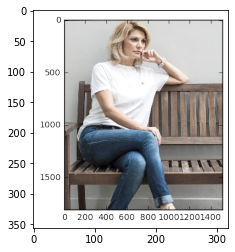

In [38]:
imgFile = 'E:\\ndb\\spyder\\caffe\\people-face.png'
#image_file = cbook.get_sample_data(imgFile)
img = plt.imread(imgFile)
plt.imshow(img)
plt.show()

In [ ]:
face_detection(imgFile)

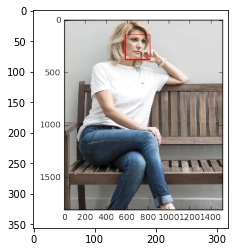

In [5]:
imgFile = 'E:\\ndb\\spyder\\caffe\\people-face-result.png'
img = plt.imread(imgFile)
plt.imshow(img)
plt.show()